In [1]:
import os
import json
import numpy as np

experiment_dir = "../experiments/random_architectures_with_loss"
dir_depth      = 4

# Get list of json files
filenames = [f for f in os.listdir(experiment_dir) if os.path.isfile(os.path.join(experiment_dir, f))]
data = []

# Get content
for filename in filenames:
    full_path = os.path.join(experiment_dir, filename)
    config = json.load( open( full_path) )
    # Fix for old files where there was a typo
    if 'FPT' in config:
        FPT_key = 'FPT'
    elif 'FTP' in config:
        FPT_key = 'FTP'
    else:
        assert(False)
    if 'Results' in config:
        data_element = { 'filename': filename, **config[FPT_key], **config['Results'] }
    else:
        data_element = { 'filename': filename, **config[FPT_key], 'learning_curve_train': [] }
    data.append( data_element )
    
for e in data:
    print(e['filename'], ':')
    quantile_count = len(e['quantiles'])
    print( f'  |- {quantile_count} quantiles available')
    samples_count  = len(e['learning_curve_train'])
    print( f'  |- {samples_count} training samples available' )
    rounded_losses = np.round( e['learning_curve_train'], decimals=4 )
    print( f'  |- Losses ', rounded_losses )

random_Wed_Feb_9_09-31-26_2022.json :
  |- 11 quantiles available
  |- 2 training samples available
  |- Losses  [0.4444 0.435 ]
random_Wed_Feb_9_09-32-01_2022.json :
  |- 11 quantiles available
  |- 2 training samples available
  |- Losses  [0.7514 0.7634]
random_Wed_Feb_9_09-31-30_2022.json :
  |- 11 quantiles available
  |- 2 training samples available
  |- Losses  [0.644  0.6552]
random_Wed_Feb_9_09-31-10_2022.json :
  |- 11 quantiles available
  |- 2 training samples available
  |- Losses  [0.932  0.9355]
random_Wed_Feb_9_09-31-40_2022.json :
  |- 11 quantiles available
  |- 2 training samples available
  |- Losses  [0.2109 0.1901]
random_Wed_Feb_9_09-31-21_2022.json :
  |- 11 quantiles available
  |- 2 training samples available
  |- Losses  [0.7413 0.7518]
random_Wed_Feb_9_09-32-07_2022.json :
  |- 11 quantiles available
  |- 2 training samples available
  |- Losses  [0.6602 0.6895]
random_Wed_Feb_9_09-32-27_2022.json :
  |- 11 quantiles available
  |- 2 training samples availab

In [2]:
scatter_data = {}

for i in range(11):
    scatter_data[i] = []

for e in data:
    train_sample = e['learning_curve_train']
    for s in train_sample:
        for i in range(11):
            #if s < 0.5: # Remove outliers
                scatter_data[i].append( (e['quantiles'][i], s))

# Data points for each quantile
for i in range(11):
    print( i, ':', len(scatter_data[i]) )

0 : 58
1 : 58
2 : 58
3 : 58
4 : 58
5 : 58
6 : 58
7 : 58
8 : 58
9 : 58
10 : 58


Correlation measures: 
Spearman: SpearmanrResult(correlation=0.6489100715718997, pvalue=3.6073491808257284e-08)
Pearson : (0.6523078903671264, 2.8964095703373226e-08)
R2      : 0.6523078903671262


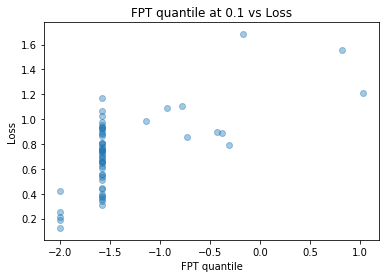

Correlation measures: 
Spearman: SpearmanrResult(correlation=0.6515044682235025, pvalue=3.051464612040597e-08)
Pearson : (0.6487444541801346, 3.645896459361343e-08)
R2      : 0.6487444541801349


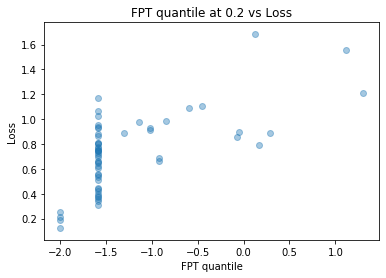

Correlation measures: 
Spearman: SpearmanrResult(correlation=0.6263854511850426, pvalue=1.4462980292135343e-07)
Pearson : (0.6323161675920143, 1.014300743225693e-07)
R2      : 0.6323161675920145


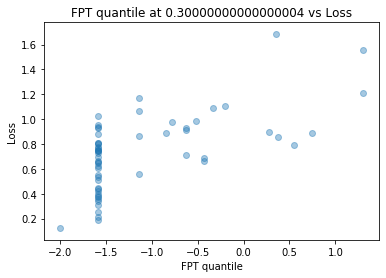

Correlation measures: 
Spearman: SpearmanrResult(correlation=0.5591699254177704, pvalue=5.055921600680414e-06)
Pearson : (0.5765256474159665, 2.177326566296885e-06)
R2      : 0.5765256474159666


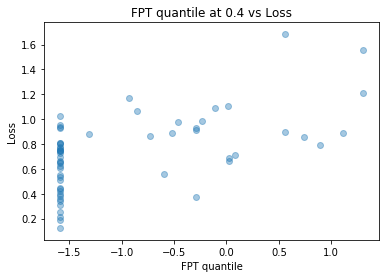

Correlation measures: 
Spearman: SpearmanrResult(correlation=0.4359220023392874, pvalue=0.0006252498446110915)
Pearson : (0.5102700316879906, 4.27780535082517e-05)
R2      : 0.5102700316879906


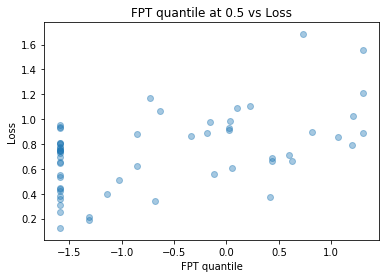

Correlation measures: 
Spearman: SpearmanrResult(correlation=0.390677370816725, pvalue=0.002429122030303166)
Pearson : (0.39639582086155883, 0.0020671987849925333)
R2      : 0.396395820861559


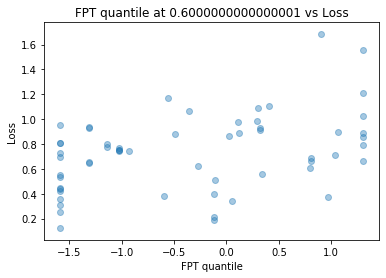

Correlation measures: 
Spearman: SpearmanrResult(correlation=0.22977938863182515, pvalue=0.08271354701859997)
Pearson : (0.28227091288971023, 0.031810814798319764)
R2      : 0.2822709128897103


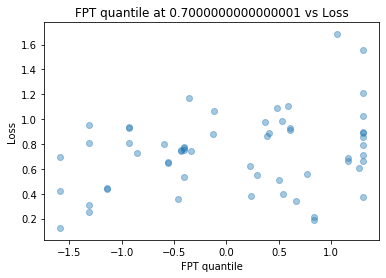

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.008690195878239656, pvalue=0.9483785947093515)
Pearson : (0.11132418700479013, 0.40543478672071553)
R2      : 0.11132418700479009


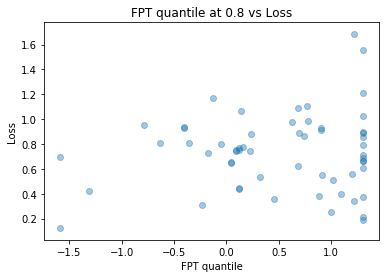

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.18550892675565425, pvalue=0.16326510816246512)
Pearson : (-0.01133099435880942, 0.9327237521223416)
R2      : -0.011330994358809438


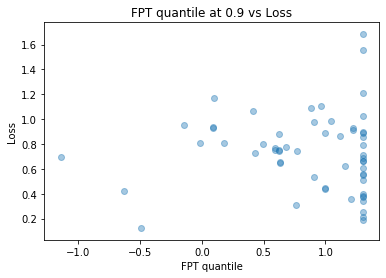

In [5]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Means 

# Quantiles
for i in range(1,10):
    # Bivariate analysis of quantiles and losses
    x = [np.log10(x+0.01) for (x,y) in scatter_data[i]]
    y = [y for (x,y) in scatter_data[i]]
    spearman = scipy.stats.spearmanr(x, y)
    pearson  = scipy.stats.pearsonr(x, y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print("Correlation measures: ")
    print("Spearman:", spearman )
    print("Pearson :", pearson  )
    print("R2      :", r_value)
    # Plot
    plt.scatter( x, y , alpha=0.4)
    plt.title(f'''FPT quantile at {i*0.1} vs Loss''')
    plt.xlabel("FPT quantile")
    plt.ylabel("Loss")
    plt.savefig(f'''FTP_quantile{i*10}.png''')
    plt.show()


In [4]:
!pip install scipy


Correlation measures: (correlation, p_value)
Spearman: 0.6489100715718997 3.6073491808257284e-08
Pearson : (0.7140640443610654, 3.115459732770531e-10)
R2      : 0.7140640443610649
Spearman: 0.6515044682235025 3.051464612040597e-08
Pearson : (0.7041804995358798, 6.951760562954189e-10)
R2      : 0.7041804995358798
Spearman: 0.6263854511850426 1.4462980292135343e-07
Pearson : (0.6524037368685228, 2.8784161841852755e-08)
R2      : 0.6524037368685232
Spearman: 0.5591699254177704 5.055921600680414e-06
Pearson : (0.5793343758362571, 1.8911428160272987e-06)
R2      : 0.5793343758362572
Spearman: 0.4359220023392874 0.0006252498446110915
Pearson : (0.5062884724692067, 5.018968375060424e-05)
R2      : 0.5062884724692068
Spearman: 0.390677370816725 0.002429122030303166
Pearson : (0.39910502036586387, 0.0019131789020604203)
R2      : 0.399105020365864
Spearman: 0.22977938863182515 0.08271354701859997
Pearson : (0.28721610995161334, 0.028812448267045935)
R2      : 0.2872161099516134
Spearman: -0.008

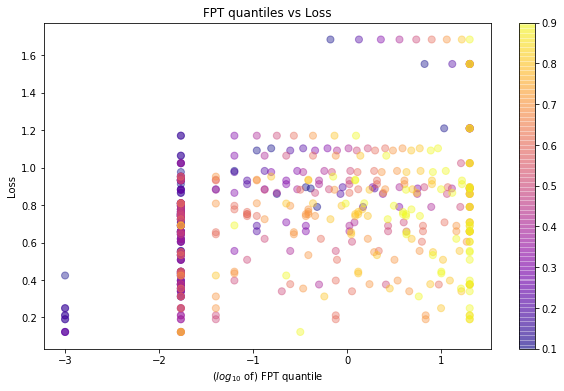

In [6]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Means 

# Quantiles
fig = plt.figure( figsize = (10,6) )
ax  = fig.add_subplot( 111 )
final_x = []
final_y = []
final_c = []
print("Correlation measures: (correlation, p_value)")
for i in range(1,10):
    # Bivariate analysis of quantiles and losses
    x = [np.log10(x+0.001) for (x,y) in scatter_data[i]]
    #x = [x for (x,y) in scatter_data[i]]
    y = [y for (x,y) in scatter_data[i]]
    spearman = scipy.stats.spearmanr(x, y)
    pearson  = scipy.stats.pearsonr(x, y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print("Spearman:", spearman[0], spearman[1] )
    print("Pearson :", pearson  )
    print("R2      :", r_value)
    # Plot
    color = [i*0.1]*len(x)
    final_x = final_x + x
    final_y = final_y + y
    final_c = final_c + color
#
scale = 50
plt.scatter( final_x, final_y, alpha=0.4, c=final_c, s=scale, cmap='plasma')
plt.colorbar()
plt.title(f'''FPT quantiles vs Loss''')
plt.xlabel("($log_{10}$ of) FPT quantile")
plt.ylabel("Loss")
plt.savefig(f'''FTP_quantile{i*10}.png''')
plt.show()
